# Super resolution - Photo Enhancement

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

from pathlib import Path

In [2]:
path = Path('./data/DIV2K')

In [3]:
folder = 'DIV2K'
dest = path/folder

In [4]:
! unzip -q -n {dest}/DIV2K_valid_HR.zip -d {dest}
! unzip -q -n {dest}/images.tar.zip -d {dest}

In [4]:
path.ls()

[PosixPath('data/DIV2K/small-256'),
 PosixPath('data/DIV2K/large-512'),
 PosixPath('data/DIV2K/DIV2K'),
 PosixPath('data/DIV2K/small-96'),
 PosixPath('data/DIV2K/.ipynb_checkpoints')]

## View Data

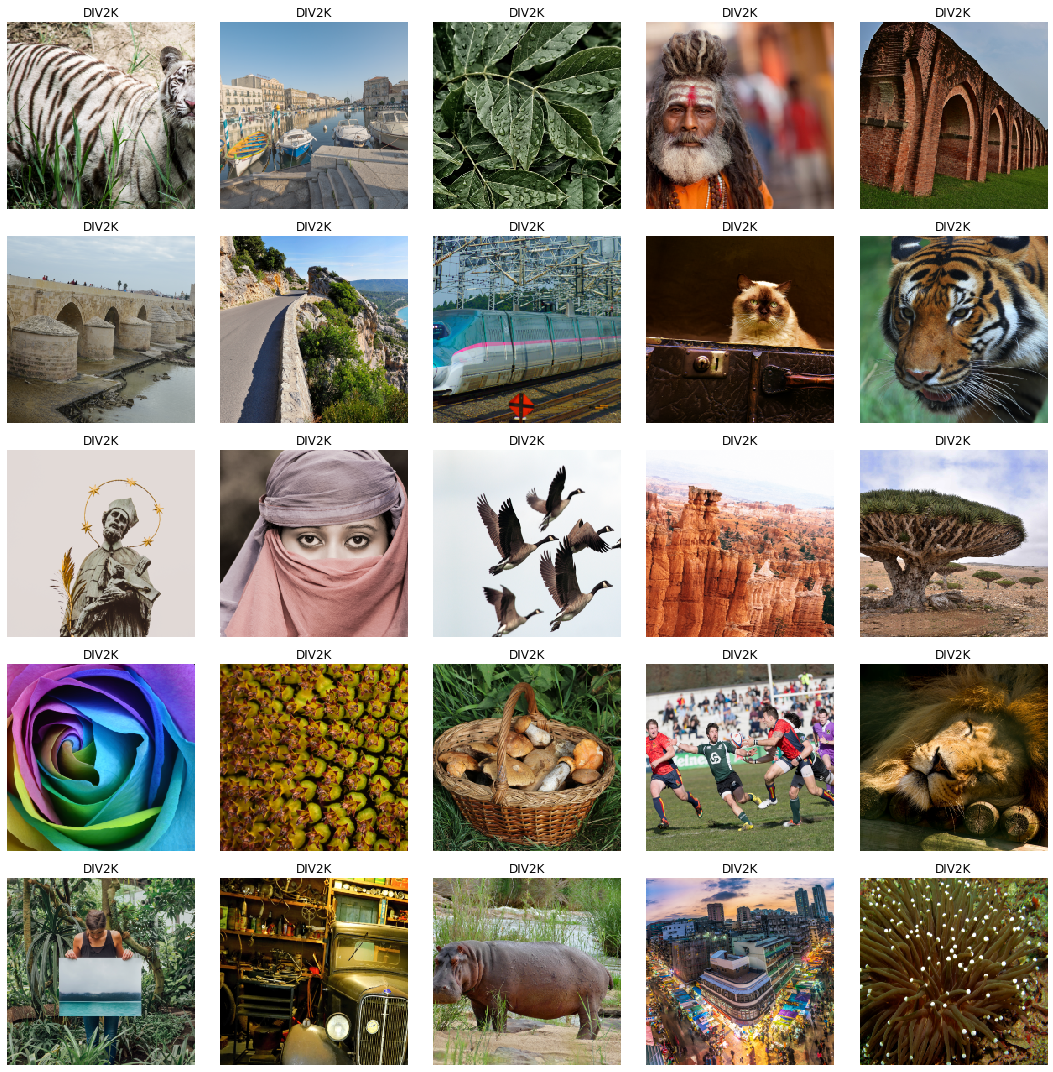

In [8]:
data.show_batch(row=3, figsize=(15,15))

In [5]:
path_l = Path('./data/DIV2K/DIV2K')
path_lr = Path('./data/DIV2K/small-96')
path_mr = Path('./data/DIV2K/small-256')
path_xr = Path('./data/DIV2K/large-512')

In [6]:
# ImageList (ItemList) - regroups the inputs for our model in items and 
# saves a path attribute which is where it will look for any files 

il = ImageList.from_folder(path_l)

In [7]:
# convert photos into lower jpg quality. 
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_l)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=30)

In [8]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256), (path_xr, 512)]
for p, size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [9]:
# model - resnet34
# split 10% of the data to validation set. 
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [10]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_l/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    data.c = 3
    return data

In [11]:
data = get_data(bs, size)

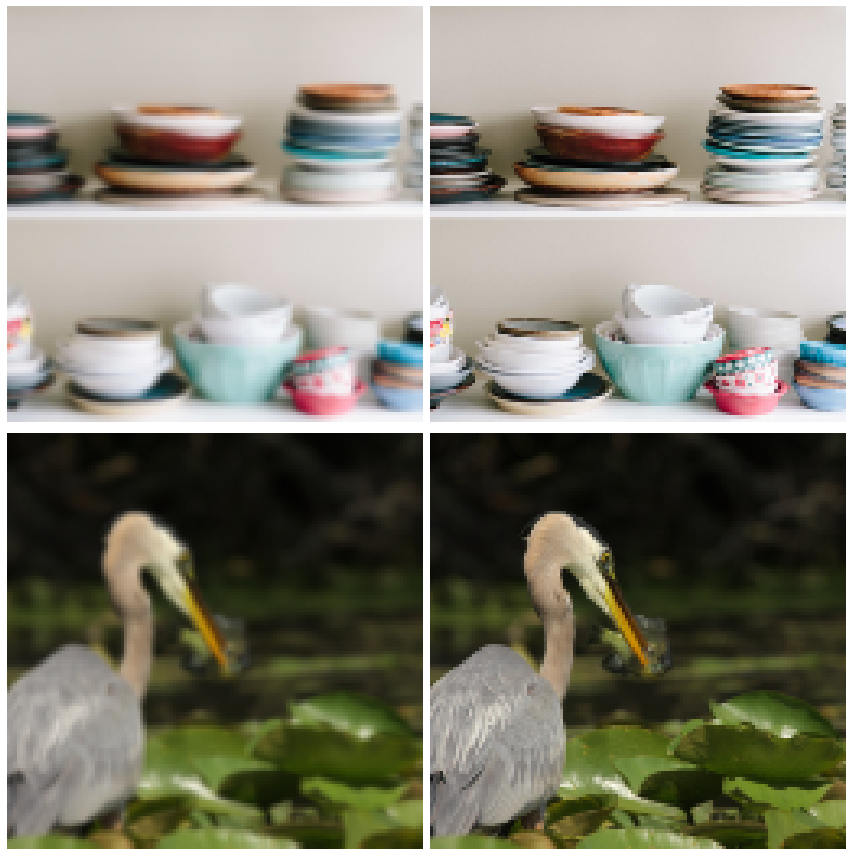

In [13]:
# low resolutioned image (left) and original image (right). 
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(12,12))

## Feature loss

In [12]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [13]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [14]:
gram_matrix(t)

tensor([[[0.1854, 0.1790, 0.1745],
         [0.1790, 0.1751, 0.1711],
         [0.1745, 0.1711, 0.1679]],

        [[0.1854, 0.1790, 0.1745],
         [0.1790, 0.1751, 0.1711],
         [0.1745, 0.1711, 0.1679]]])

In [15]:
base_loss = F.l1_loss

In [16]:
# .features contains the convolutional part of the model. Don't need the head, just the intermediate activations. 
# vgg - pre-trained ImageNet network.
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [17]:
# enumerate the children and find the maxpooling layers. 
# grab i-1, layer before it changes. 
# output - list of layer numbers just before the max pooling layers.
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [18]:
# FeatureLoss - compares the target and generated version of the image. 
# .loss_features = all features
# .hooks - how pytorch grabs intermediate layers. 

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
                ] + [f'gram_{i}' for i in range(len(layer_ids))]

# passes target(actual y) call vgg model, go through all stored models, and clone. 
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]

# input - output of the generator
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        #.feat_losses - L1 loss between the pixels
        self.feat_losses = [base_loss(input, target)]
        # go thru all blocks and get L1
        self.feat_losses += [base_loss(f_in, f_out)*w
                            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        # prints out all the separate layer loss amounts
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [19]:
# When calling FeatureLoss, pass in pre-trained model (m_feat).
# grab all the layers from the network.
# hook outputs -> forward
# make feat (target - out_feat)
# get L1 loss then return sum
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [22]:
wd = 1e-3
 
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                    blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


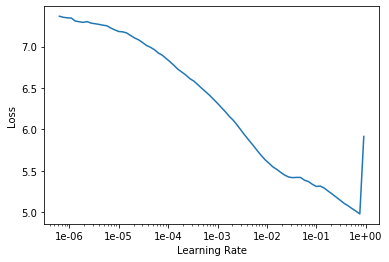

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
lr = 1e-3

In [25]:
# fit one cycle, saves the model, shows the results. 
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

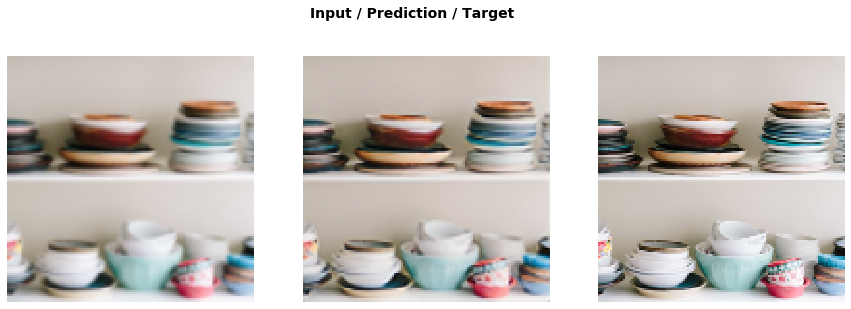

In [26]:
# displays also pixel loss, loss at each layers, and gram loss
do_fit('la_512px_30qty', slice(lr*10))

In [27]:
learn.unfreeze()

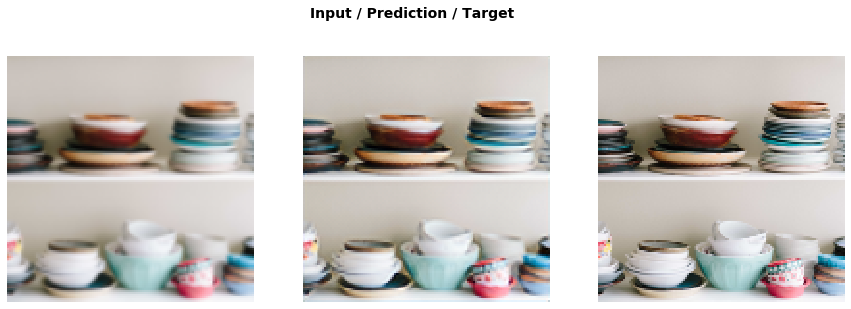

In [28]:
do_fit('1b_512px_30qty', slice(1e-5,lr))

In [29]:
# double the size - need half the batch size to avoid GPU out of memory.
data = get_data(bs//2,size*2)

In [30]:
learn.data = data
learn.freeze()
gc.collect()

21023

In [31]:
learn.load('1b_512px_30qty');

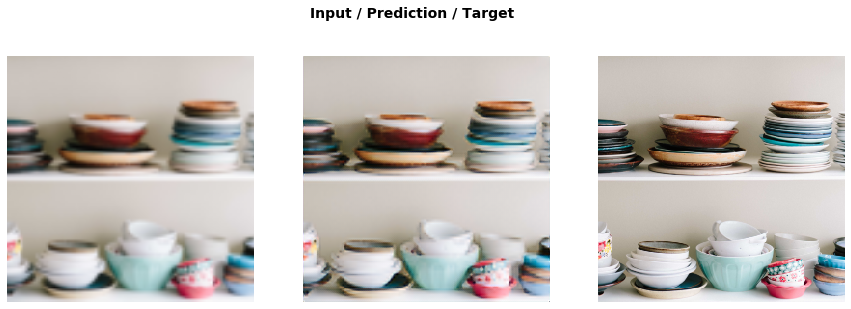

In [32]:
do_fit('2a_512px_30qty')

In [33]:
learn.unfreeze()

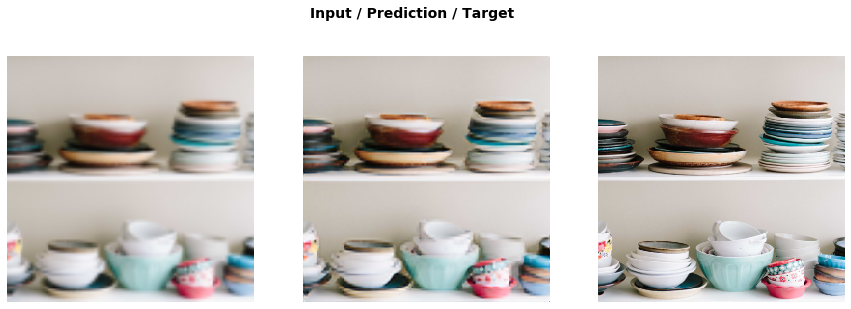

In [34]:
# final result without using GAN
do_fit('2b_512px_30qty', slice(1e-6,1e-4), pct_start=0.3)

In [35]:
learn.save('2b_512px_30qty')

## Test

In [20]:
learn = None
gc.collect();

In [21]:
# 2:3 ratio of the image
512/764*1024

686.2408376963351

In [22]:
# 2:3 ratio of the image
512/764*1600

1072.2513089005236

In [49]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1072, 1600) # >  8GB RAM
else:           size=( 686, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1072, 1600), have 9918MB of GPU RAM free


In [50]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [51]:
# can start with med size jpeg 512 instead of low res 96
data_xr = (ImageImageList.from_folder(path_xr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_l/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_xr.c = 3

In [52]:
learn.load('2b_512px_30qty');

In [53]:
learn.data = data_xr

In [54]:
fn = data_xr.valid_ds.x.items[3]; fn

PosixPath('data/DIV2K/large-512/0267.png')

In [55]:
img = open_image(fn); img.shape

torch.Size([3, 512, 770])

In [56]:
p,img_hr,b = learn.predict(img)

In [57]:
img.shape

torch.Size([3, 512, 770])

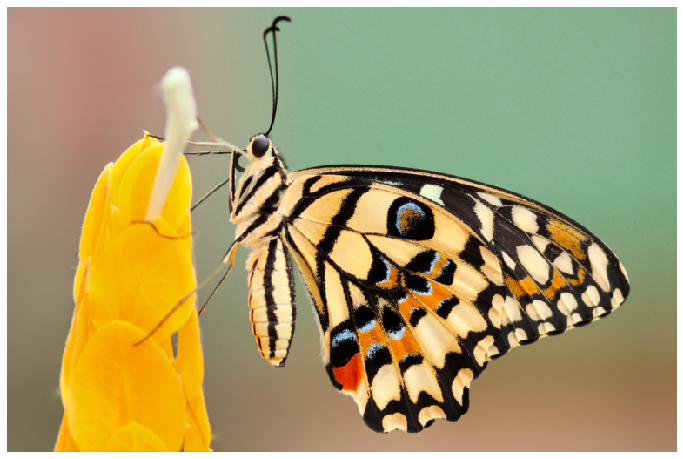

In [58]:
show_image(img, figsize=(12,18), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


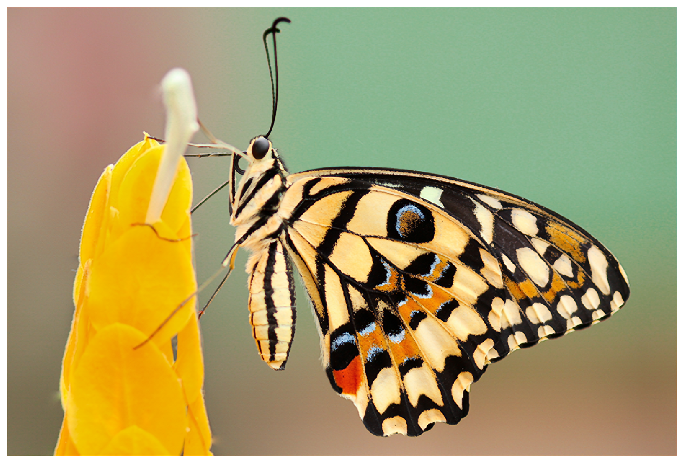

In [59]:
Image(img_hr).show(figsize=(12,18))

In [51]:
learn.export()

# Production

In [2]:
# production path
path_prod = Path('./data/DIV2K_Prod')

In [3]:
# load export pkl for prod
learn = load_learner(path_prod, 'Super Resolution DVI2K_030920_512px_30qty.pkl')

In [4]:
#prod image
fn = Path('./data/DIV2K_Prod/El_Matador.jpg')
img = open_image(fn)
img.shape

torch.Size([3, 2670, 4000])

In [5]:
p,img_hr,b = learn.predict(img)

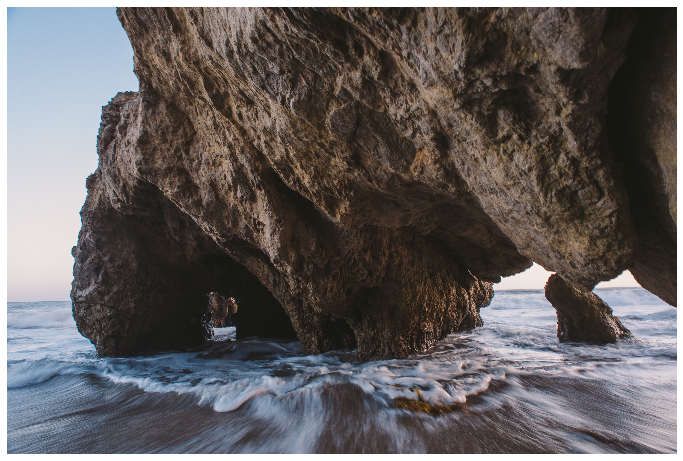

In [6]:
show_image(img, figsize=(12,18), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


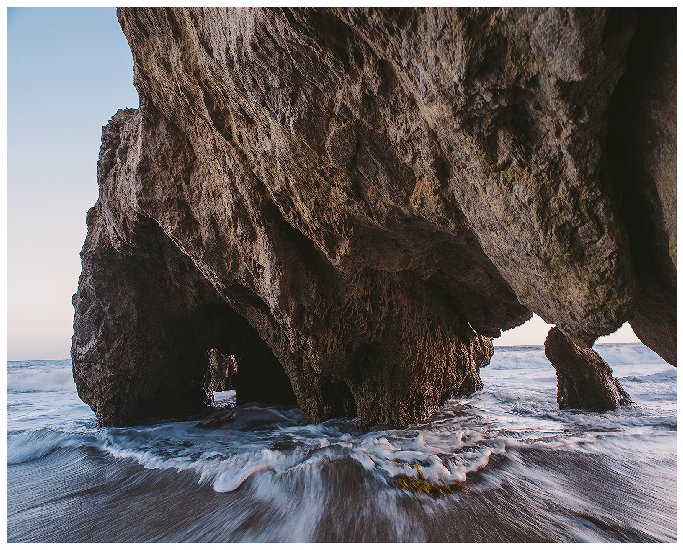

In [7]:
Image(img_hr).show(figsize=(12,18))

In [8]:
img_hr.shape

torch.Size([3, 1280, 1600])